---
title: Effect of training hyperparameters
---

In [1]:
%matplotlib ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from itertools import chain, product
from functools import reduce

from ipywidgets import Select, SelectMultiple, ToggleButton, Layout, Label

from IPython.display import display
from ipywidgets import HBox, VBox

In [3]:
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["legend.title_fontsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

In [4]:
with open("mini_df.pkl", "rb") as f:
    df = pickle.load(f)

In [5]:
def reduction(series, mode):
    match mode:
        case "mean":
            return series.mean()
        case "min":
            return series.min()
        case "max":
            return series.max()
        case "median":
            return series.median()
        case _:
            return ValueError

In [6]:
def n_image_select():
    return SelectMultiple(
        options=[64, 128, 256, 512],
        value=[64, 128, 256, 512],
        rows=4,
        # description="Number of training images",
        disabled=False,
        layout={"width": "100px", "height":"88px"},
    )


def pretrain_lr_select():
    return SelectMultiple(
        options=["1e-3", "1e-4"],
        value=["1e-3", "1e-4"],
        rows=2,
        # description="Pretrain LRs",
        disabled=False,
        layout={"width": "100px"},
    )


def transfer_lr_select():
    return SelectMultiple(
        options=["1e-4", "1e-5"],
        value=["1e-4", "1e-5"],
        rows=2,
        # description="Transfer LRs",
        disabled=False,
        layout={"width": "100px"},
    )


def weight_freezing_select():
    return SelectMultiple(
        options=["none", "decoder", "encoder"],
        value=["none", "decoder", "encoder"],
        # description="Weight freezing",
        rows=3,
        disabled=False,
        layout={"width": "100px"},
    )


def reduction_select():
    return Select(
        options=["min", "mean", "median", "max"],
        value="mean",
        rows=4,
        # description="Data Reduction",
        disabled=False,
        layout={"width": "100px"},
    )

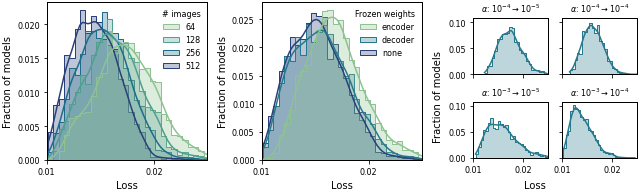

In [ ]:
# | label: app:hp_widget
### Interactive settings
filter_zero = False  # Button

# All filter selections
N_points = [64, 128, 256, 512]
weight_freezing = ["encoder", "decoder", "None"]
active_lr_pairs = ((1e-4, 1e-5), (1e-4, 1e-4), (1e-3, 1e-5), (1e-3, 1e-4))


### Figure and style set up



ratio = 2.5 / 8.25
dpi = 72
width = 620 / dpi
height = width * ratio
fig_style = {
    "figsize": (width, height),  # inches
    "constrained_layout": True,
    "dpi":dpi
}


fig = plt.figure(**fig_style)
subfig_gs = fig.add_gridspec(1, 3)
all_axes = []

common_style = {
    "kde": True,
    "fill": True,
    "multiple": "layer",
    "stat": "probability",
    "common_bins": True,
    "element": "step",
    "cumulative": False,
    "alpha": 0.3,
    "binwidth": 5e-4,
    "kde_kws": {
        "bw_adjust": 1.0,
    },
}

Nc = 11
palette_0 = sns.color_palette("crest", Nc)

## Dependence on dataset size
fig_tl_size = fig.add_subfigure(subfig_gs[0])
gs_tl_size = fig_tl_size.add_gridspec(1, 1)
ax_tl_size = fig.add_subplot(gs_tl_size[0])
all_axes.append(ax_tl_size)

## Dependence on weight freezing
fig_weight_freezing = fig.add_subfigure(subfig_gs[1])
gs_weight_freezing = fig_weight_freezing.add_gridspec(1, 1)
ax_weight_freezing = fig.add_subplot(gs_weight_freezing[0])
all_axes.append(ax_weight_freezing)

## Dependence on learning rate/learning rate ratio
fig_lr = fig.add_subfigure(subfig_gs[2])
lr_style = {
    **common_style,
    "color": palette_0[Nc // 2 + 1],
}
lr_axes = []
gs_lr = fig_lr.add_gridspec(2, 2, wspace=0, hspace=0)
ax_p1t1 = fig.add_subplot(gs_lr[0, 0])
ax_p1t2 = fig.add_subplot(gs_lr[0, 1])
ax_p2t1 = fig.add_subplot(gs_lr[1, 0])
ax_p2t2 = fig.add_subplot(gs_lr[1, 1])

all_axes.extend((ax_p1t1, ax_p1t2, ax_p2t1, ax_p2t2))
lr_axes = ((ax_p1t1, ax_p1t2), (ax_p2t1, ax_p2t2))


size_style = {
    **common_style,
    "palette": [palette_0[i] for i in (0, Nc // 3, 2*Nc // 3, Nc - 1)],
}

weight_style = {
    **common_style,
    "palette": [palette_0[i] for i in (0, Nc // 2 + 1, Nc - 1)],
}


fig_lr.supxlabel("Loss", fontsize=10)
fig_lr.supylabel('Fraction of models', fontsize=10)

### Widgets
ndata_select = n_image_select()
ptlr_select = pretrain_lr_select()
tllr_select = transfer_lr_select()
freeze_select = weight_freezing_select()
filter_zero_button = ToggleButton(
    value=True,
    description="Filter zero defocus",
    style={"font_size": "8pt"},
    layout={"width": "125px"},
)


center_align = Layout(align_items="center")
ptlr_box = VBox([Label("Pretrain LR"), ptlr_select], layout=center_align)
tllr_box = VBox([Label("Transfer LR"), tllr_select], layout=center_align)
ndata_box = VBox([Label("# of training images"), ndata_select], layout=center_align)
freeze_box = VBox([Label("Weight Freezing"), freeze_select], layout=center_align)
# rmode_box = VBox(
#     [filter_zero_button], layout={"align_items": "center", "width": "150px"}
# )

left_box = VBox(
    [ndata_box, freeze_box], layout={"align_items": "center", "width": "150px"}
)
right_box = VBox(
    [
        ptlr_box,
        tllr_box,
        Label(""),
        filter_zero_button
    ],
    layout={"align_items": "center", "width": "150px"},
)

# full_box = VBox([HBox([left_box, right_box]), rmode_box], layout=center_align)
full_box = HBox([left_box, right_box], layout=center_align)


display(full_box)
# [display(w) for w in (ndata_select, ptlr_select, tllr_select, freeze_select, filter_zero_button)]


def update_plot(*args):
    filter_zero = filter_zero_button.value
    N_points = ndata_select.value
    weight_freezing = freeze_select.value
    pretrain_lrs = ptlr_select.value
    transfer_lrs = tllr_select.value
    active_lr_pairs = tuple(product(pretrain_lrs, transfer_lrs))

    if filter_zero:
        base_df = df.query("transfer_defocus != 0.0")
    else:
        base_df = df.copy()

    lr_query = reduce(
        lambda x, y: f"{x} or {y}",
        (f"(pretrain_lr == {x} and transfer_lr == {y})" for x, y in active_lr_pairs),
    )

    plot_df = base_df.query(
        f"N_tl_training_points in {N_points} and freeze_option in {weight_freezing}"
    ).query(lr_query)

    ax_tl_size.clear()
    sns.histplot(
        ax=ax_tl_size,
        data=plot_df,
        x="best_target_transfer_performance",
        hue="N_tl_training_points",
        **size_style,
    )

    ax_tl_size.get_legend().set_title("# images")
    ax_tl_size.set_ylabel("Fraction of models")
    ax_tl_size.get_legend().set_alignment("right")
    ax_tl_size.set_xlabel("Loss")

    ax_weight_freezing.clear()
    sns.histplot(
        ax=ax_weight_freezing,
        data=plot_df,
        x="best_target_transfer_performance",
        hue="freeze_option",
        hue_order=["encoder", "decoder", "none"],
        **weight_style,
    )

    ax_weight_freezing.set_xlabel("Loss")
    ax_weight_freezing.set_ylabel("Fraction of models")
    ax_weight_freezing.get_legend().set_title("Frozen weights")
    ax_weight_freezing.get_legend().set_alignment("right")

    ## Dependence on weight freezing
    all_lr_pairs = [(1e-4, 1e-5), (1e-4, 1e-4), (1e-3, 1e-5), (1e-3, 1e-4)]
    for ax, lrs in zip([ax_p1t1, ax_p1t2, ax_p2t1, ax_p2t2], all_lr_pairs):
        ax.clear()
        r_df = plot_df.query(f"pretrain_lr=={lrs[0]} and transfer_lr=={lrs[1]}")
        if len(r_df) > 0:
            sns.histplot(
                ax=ax,
                data=r_df,
                x="best_target_transfer_performance",
                **lr_style,
                label=f"LR: {lrs}",
            )

        ax.set_title(
            f"$\\alpha$: $10^{{ {int(np.log10(lrs[0]))} }} \\rightarrow 10^{{ {int(np.log10(lrs[1]))} }}$",
            fontsize=8,
        )

        ax.set_ylabel('')



    common_ymax = reduce(
        lambda x, y: max(x, y), [ax.get_ylim()[1] for ax in chain(*lr_axes)]
    )
    for ax in chain(*lr_axes):
        ax.set_xlabel("")
        ax.set_ylim(0, common_ymax)

    for ax in lr_axes[0]:
        ax.set_xticklabels([])

    for row in lr_axes:
        row[-1].set_yticklabels([])
        row[-1].set_ylabel("")

    for ax in all_axes:
        plt.setp(ax.spines.values(), linewidth=1.0)
        if filter_zero:
            ax.set_xlim(0.01, 0.025)
            ax.set_xticks(
                [
                    0.01,
                    0.02,
                ]
            )
        else:
            ax.set_xlim(0.01, 0.07)


update_plot()
ndata_select.observe(update_plot, "value")
ptlr_select.observe(update_plot, "value")
tllr_select.observe(update_plot, "value")
freeze_select.observe(update_plot, "value")
filter_zero_button.observe(update_plot, "value")